# Urban Simulation Assessment code

In [24]:
%reset -f

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import numpy as np

## Part 1: London's underground resilience

In [26]:
# Reading in the network data
G = nx.read_graphml('london.graph.xml')

In [27]:
# Checking data
print(nx.info(G))
list(G.nodes(data = True))[0]

Graph with 401 nodes and 467 edges


('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [28]:
# Fixing the data type
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [29]:
# To check node attributes:
list(G.nodes(data = True))[0:3]

[('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)}),
 ('Kingsbury', {'coords': (519359.9688603217, 188721.22027255083)}),
 ('Queensbury', {'coords': (518811.3613368616, 189760.50737704366)})]

In [30]:
# To check edge attributes:
list(G.edges(data = True))[0:3]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.1659381957816, 'line_name': 'Jubilee', 'flows': 6744}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657633037, 'line_name': 'Metropolitan', 'flows': 36601})]

In [31]:
# Remove Nine Elms and Battersea Park
G.remove_node('Nine Elms')
G.remove_node('Battersea Park')

In [32]:
# Add inverse flow:
inv_flows={(e1, e2):(round(1./flows,7)) for e1, e2, flows in G.edges(data='flows')}

# Let us add the inversed flows as an attribute to the edges in the graph
nx.set_edge_attributes(G, inv_flows, 'inv_flows')

# Print edge list with attributes
list(G.edges(data = True))[0:3]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.7715580506483,
   'line_name': 'Jubilee',
   'flows': 12356,
   'inv_flows': 8.09e-05}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.1659381957816,
   'line_name': 'Jubilee',
   'flows': 6744,
   'inv_flows': 0.0001483}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657633037,
   'line_name': 'Metropolitan',
   'flows': 36601,
   'inv_flows': 2.73e-05})]

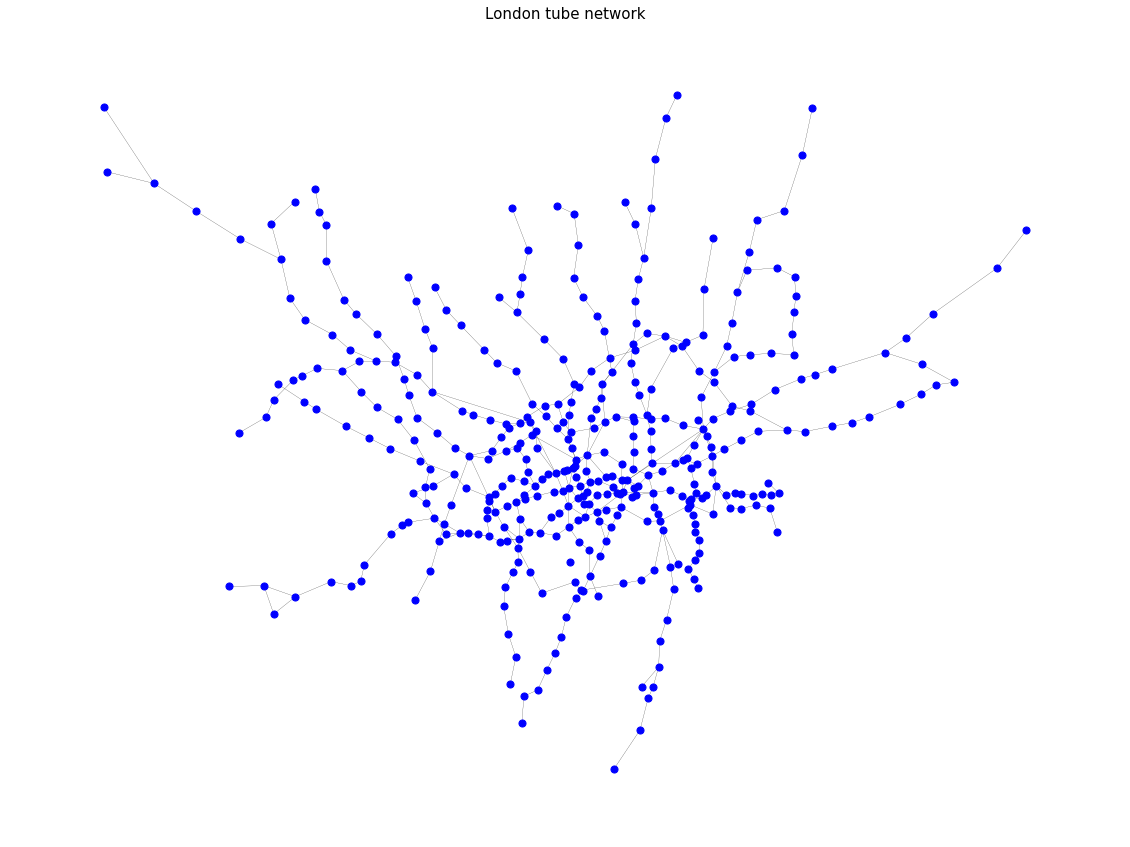

In [33]:
# Final check

#Setting up the positioning
fig, ax = plt.subplots(figsize=(20,15))
pos = nx.get_node_attributes(G, 'coords')
#Setting up the labels
node_labels = nx.get_node_attributes(G, 'station_name')

#Plot
nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

### I. Topological network
This part models London's underground as a topological (unweighted) network

#### I.1. Centrality measures
**Definitions from: Latora and Marchiori - 2007 - A measure of centrality based on network efficiency**
- Measure 1: degree centrality
- Measure 2: (topological) closeness centrality
- Measure 3: (topological) betweenness centrality

| Centrality measure (topological) | Definition | Equation for node ${i}$ (normalised) | Meaning for London underground | Importance for London underground
| :- | :- | :-: | :- | :- |
| Degree centrality | Number of direct ties a node has, normalised by potential neighbour count | ${C}^{D}_{i}=\frac{{k}_{i}}{N-1}$ <br> where ${k}_{i}$ is the number of direct ties| How many stations are directly connected to a node ${i}$ | Higher ${C}^{D}_{i}$ implies that the stations has multiple lines going through, functioning as a connecting station. Shut down of this station would prevent smooth transit between multiple lines, postentially isolating some stations that are not shutdown.
| Closeness centrality | Reciprocal of the average geodesic distance from a node to all the other nodes | ${C}^{C}_{i}=\frac{N-1}{\sum{{d}_{ij}}}$ <br> where ${j}\neq{i}$ | How accessible a station is to all the rest of the stations in terms of geodesic path lengths | Higher ${C}^{C}_{i}$ implies that the station is easily accessible and therefore well-located for living and work. Shut-down of this station would likely cause inconvenience to a large number of commuters trying to get to this station.
| Betweenness centrality | Number of geodesic linking two nodes passing through a node ${i}$, normalised by the number of geodesic paths in the network | ${C}^{B}_{i}=\frac{\sum\limits_{j}{\sum\limits_{k}{{n}_{jk}({i})}/{n}_{jk}}}{(N-1)(N-2)}$ <br> where ${j}\neq{i}$ and ${k}\neq{i}$, ${k}\neq{j}$ | How important a station is in enabling the shortest travel from origin to destination, assuming an equal probability of travels for all pair of stations | Higher ${C}^{B}_{i}$ implies the station is used frequently to get from one station to another, so the shutdown of this station would impact large number of travels. Furthermore, this station is likely a connector between multiple components, so the shutdown could lead to breaking-up of the network into components.

*Table 1. Centrality measure summary, where ${N}$ is the total node count in London underground*

In [289]:
# Computing each measures - degree centrality
degree_dict =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_dict),'degree')

In [35]:
# Computing each measures - closeness centrality
closeness_t_dict =nx.closeness_centrality(G)
nx.set_node_attributes(G,dict(closeness_t_dict),'closeness_t')

In [36]:
# Computing each measures - betweenness centrality
betweenness_t_dict =nx.betweenness_centrality(G)
nx.set_node_attributes(G,dict(betweenness_t_dict),'betweenness_t')

In [37]:
# Creating a dataframe with station name and 3 centrality measures
df = pd.DataFrame()
df['station_name'] = G.nodes()
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
df['topological closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df['topological betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

In [38]:
# Check the top 10 for degree centrality
df_sorted_deg = df.sort_values(["degree"], ascending=False)
df_sorted_deg[['station_name', 'degree']][0:11]

,station_name,degree
Stratford,Stratford,0.022613
Bank and Monument,Bank and Monument,0.020101
King's Cross St. Pancras,King's Cross St. Pancras,0.017588
Baker Street,Baker Street,0.017588
Earl's Court,Earl's Court,0.015075
Oxford Circus,Oxford Circus,0.015075
Liverpool Street,Liverpool Street,0.015075
Waterloo,Waterloo,0.015075
Green Park,Green Park,0.015075
Canning Town,Canning Town,0.015075


In [39]:
# Check the top 10 for topological closeness centrality
df_sorted_clos = df.sort_values(["topological closeness"], ascending=False)
df_sorted_clos[['station_name', 'topological closeness']][0:10]

,station_name,topological closeness
Green Park,Green Park,0.114253
King's Cross St. Pancras,King's Cross St. Pancras,0.113208
Bank and Monument,Bank and Monument,0.112982
Westminster,Westminster,0.111992
Waterloo,Waterloo,0.111644
Oxford Circus,Oxford Circus,0.110770
Bond Street,Bond Street,0.110553
Farringdon,Farringdon,0.110430
Angel,Angel,0.110430
Moorgate,Moorgate,0.109818


In [40]:
# Check the top 10 for topological closeness centrality
df_sorted_bet = df.sort_values(["topological betweenness"], ascending=False)
df_sorted_bet[['station_name', 'topological betweenness']][0:10]

,station_name,topological betweenness
Stratford,Stratford,0.298351
Bank and Monument,Bank and Monument,0.288474
Liverpool Street,Liverpool Street,0.270703
King's Cross St. Pancras,King's Cross St. Pancras,0.256646
Waterloo,Waterloo,0.236992
Green Park,Green Park,0.213964
Euston,Euston,0.209004
Westminster,Westminster,0.200884
Baker Street,Baker Street,0.191711
Finchley Road,Finchley Road,0.165258


##### Output table:

| Rank | Degree centrality || Closeness centrality || Betweenness centrality ||
| -: | -: | :- | -: | :- | -: | :- |
| <b>1</b> | Stratford | 0.0226 | Green Park | 0.1143 | Stratford | 0.2984 |
| <b>2</b> | Bank and Monument  | 0.0201 | King's Cross St. Pancras | 0.1132 | Bank and Monument | 0.2885 |
| <b>3</b> | King's Cross St. Pancras | 0.0176 | Bank and Monument | 0.1130 | Liverpool Street | 0.2707 |
| <b>4</b> | Baker Street | 0.0176 | Westminster | 0.1120 | King's Cross St. Pancras | 0.2566 |
| <b>5</b> | Earl's Court | 0.0151 | Waterloo | 0.1116 | Waterloo | 0.2370 |
| <b>6</b> | Oxford Circus | 0.0151 | Oxford Circus | 0.1110 | Gren Park |0.2140 |
| <b>7</b> | Liverpool Street | 0.0151 | Bond Street | 0.1106 | Euston | 0.2090 |
| <b>8</b> | Waterloo | 0.0151 | Farringdon | 0.1104 | Westminster | 0.2009 |
| <b>9</b> | Green Park | 0.0151 | Angel | 0.1104 | Baker Street | 0.1917 |
| <b>10</b> | Canning Town | 0.0151 | Moorgate | 0.1098 | Finchley Road | 0.1653 |
| <b>11</b> | West Ham | 0.0151 | - | - | - | - |

*Table 2. Centrality measure computed results*

#### I.2. Impact measures - refer to word doc
- Number of stations in the largest component
- Average shortest path per station in the largest component

In [41]:
def maxsize_comp(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return G_maxsub.number_of_nodes()

In [42]:
def avg_length(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return nx.average_shortest_path_length(G_maxsub)

In [43]:
maxsize_comp(G)

398

In [44]:
avg_length(G)

13.567155677632496

(Removed -->)
<!--
**Definitions from: Efficiency measure_Latora and Marchiori (2001)_Efficient Behavior of Small-World Networks**
- Measure 1: Local efficiency - returns the average local efficiency of the graph. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.local_efficiency.html#networkx.algorithms.efficiency_measures.local_efficiency
- Measure 2: Global efficiency - returns the average global efficiency of the graph. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency
-->

In [45]:
'''
def global_efficiency_weighted(G):
    n = len(G)
    d_sum = 0
    denom = n * (n - 1)
    #shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = 'inv_flows'))
    shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = None))

    for u in range(0, n):
        for key in shortest_paths[u][1]:
            d_sum = d_sum + (1/shortest_paths[u][1][key] if shortest_paths[u][1][key] !=0 else 0)
    
    g_eff = d_sum/ denom
    return g_eff
'''

"\ndef global_efficiency_weighted(G):\n    n = len(G)\n    d_sum = 0\n    denom = n * (n - 1)\n    #shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = 'inv_flows'))\n    shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = None))\n\n    for u in range(0, n):\n        for key in shortest_paths[u][1]:\n            d_sum = d_sum + (1/shortest_paths[u][1][key] if shortest_paths[u][1][key] !=0 else 0)\n    \n    g_eff = d_sum/ denom\n    return g_eff\n"

#### I.3. Node removal

In [46]:
# centrality: 'degree', 'closeness_t', or 'betweenness_t'
def node_removal(centrality:str, sequential: bool)->tuple:

    # Initialise the output dataframe
    df_sub = []
    
    # Copy the graph for this
    G_rm = G.copy()

    # Initiate a list to store impact measures
    list_num_comp = []
    list_maxsize_comp = []
    list_avg_length = []
    list_avg_length_per_node = []

    # Initial impact measures
    list_num_comp.append(nx.number_connected_components(G_rm))
    list_maxsize_comp.append(maxsize_comp(G_rm))
    list_avg_length.append(avg_length(G_rm))
    list_avg_length_per_node.append(avg_length(G_rm)/maxsize_comp(G_rm))

    # Loop - repeat for 10 nodes
    for i in range(10):

        if sequential: # Re-calculate centrality
            degree_dict =nx.degree_centrality(G_rm)
            closeness_t_dict =nx.closeness_centrality(G_rm)
            betweenness_t_dict =nx.betweenness_centrality(G_rm)
            nx.set_node_attributes(G_rm,dict(degree_dict),'degree')
            nx.set_node_attributes(G_rm,dict(closeness_t_dict),'closeness_t')
            nx.set_node_attributes(G_rm,dict(betweenness_t_dict),'betweenness_t')
            #print("centrality re-calculated")
            
        # Identify the max centrality node(s)
        centrality_list=[(i[1][centrality]) for i in G_rm.nodes(data=True)]
        max_node=[n for n in G_rm.nodes() if G_rm.nodes[n][centrality] == max(centrality_list)][0] # If multiple max centrality nodes, choose one
        station_name = [key for key, value in G_rm.nodes(data=True) if G_rm.nodes[key][centrality] == max(centrality_list)][0]
        #print("max centrality to be removed:", max(centrality_list))
        #print("node name to be removed:", station_name)
            
        # Remove the node
        G_rm.remove_node(max_node)

        # Evaluate the network efficiency
        list_num_comp.append(nx.number_connected_components(G_rm))
        list_maxsize_comp.append(maxsize_comp(G_rm))
        list_avg_length.append(avg_length(G_rm))
        list_avg_length_per_node.append(avg_length(G_rm)/maxsize_comp(G_rm))
    
    print('Number of components in the graph: ', list_num_comp)
    print('Number of nodes in the largest component: ', list_maxsize_comp) 
    print('Average shortest path of the largest component: ', list_avg_length)
    print('Average shortest path per node of the largest component: ', list_avg_length_per_node)
    
    # Adding the results to the output dataframe
    df_sub = pd.DataFrame(zip(list_num_comp, list_maxsize_comp, list_avg_length, list_avg_length_per_node), 
                          columns = ['#components', 'maxsize', 'avlength', 'avlength per node'])
        
    return(df_sub)
    

#### Strategy A: non-sequential removal of 10 most impoartant nodes (one by one)

Degree centrality

In [47]:
df_degree_A = node_removal('degree', False)
#df_degree_A

Number of components in the graph:  [2, 4, 4, 4, 5, 6, 9, 9, 9, 10, 11]
Number of nodes in the largest component:  [398, 376, 375, 374, 371, 368, 353, 352, 351, 349, 343]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 14.897654188948307, 15.712462903757652, 17.0491877322066, 17.888816490937092, 17.72516417718259, 18.167735042735043, 18.37054945054945, 18.445163521391166, 18.430242272347535]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.039727077837195486, 0.04201193289774773, 0.045954683914303504, 0.048610914377546444, 0.050212929680403945, 0.05161288364413364, 0.05233774772236311, 0.05285147140799761, 0.05373248475903071]


Closeness centrality

In [48]:
df_closeness_A = node_removal('closeness_t', False)
#df_closeness_A

Number of components in the graph:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4]
Number of nodes in the largest component:  [398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 386]
Average shortest path of the largest component:  [13.567155677632496, 13.845482533139965, 14.68879938626774, 16.012735333804535, 16.10832978132548, 16.8723191566703, 17.45506028498356, 17.487979539641945, 17.486230307824137, 17.48428431346567, 17.497880357983984]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.034875270864332404, 0.03709292774310036, 0.04053857046532794, 0.040884085739404774, 0.04293210981341043, 0.04452821501271316, 0.04472629038271597, 0.044836487968779835, 0.04494674630710969, 0.04533129626420721]


Betweenness centrality

In [49]:
df_betweenness_A = node_removal('betweenness_t', False)
#df_betweenness_A

Number of components in the graph:  [2, 4, 4, 4, 5, 5, 5, 6, 6, 7, 8]
Number of nodes in the largest component:  [398, 376, 375, 374, 368, 367, 366, 343, 342, 339, 336]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 14.897654188948307, 15.058938223107912, 16.06650574576472, 16.78917824332574, 17.207081368365895, 16.833052017799602, 16.997530483099244, 17.61784573493219, 18.023400852878463]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.039727077837195486, 0.04026454070349709, 0.04365898300479543, 0.04574707968208649, 0.047013883520125394, 0.049075953404663565, 0.04970038152952995, 0.05197004641572917, 0.05364107396690019]


#### Strategy B: Sequential removal of the most important node -> repeat

Degree centrality

In [50]:
df_degree_B = node_removal('degree', True)
#df_degree_B

Number of components in the graph:  [2, 4, 4, 4, 5, 7, 7, 7, 7, 8, 9]
Number of nodes in the largest component:  [398, 376, 375, 374, 371, 357, 356, 355, 354, 352, 338]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 14.897654188948307, 15.712462903757652, 17.0491877322066, 17.410395618921726, 17.565690773856623, 17.922988780138457, 18.51734127174661, 18.598857161357163, 21.260952013063402]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.039727077837195486, 0.04201193289774773, 0.045954683914303504, 0.048768615179052455, 0.04934182801645119, 0.05048729233841819, 0.05230887364900172, 0.05283766239021921, 0.06290222489072013]


Closeness centrality

In [51]:
df_closeness_B = node_removal('closeness_t', True)
#df_closeness_B

Number of components in the graph:  [2, 2, 2, 2, 2, 2, 3, 5, 5, 6, 6]
Number of nodes in the largest component:  [398, 397, 396, 395, 394, 393, 223, 223, 222, 193, 192]
Average shortest path of the largest component:  [13.567155677632496, 13.845482533139965, 14.68879938626774, 15.131337145794513, 16.723782952945584, 19.029638572986446, 13.942471619601664, 13.942471619601664, 14.67587949940891, 14.661539291882557, 15.585896596858639]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.034875270864332404, 0.03709292774310036, 0.038307182647581046, 0.04244614962676544, 0.048421472195894266, 0.06252229425830343, 0.06252229425830343, 0.06610756531265276, 0.07596652482840703, 0.0811765447753054]


Betweenness centrality

In [52]:
df_betweenness_B = node_removal('betweenness_t', True)
#df_betweenness_B

Number of components in the graph:  [2, 4, 4, 4, 4, 4, 5, 5, 6, 7, 8]
Number of nodes in the largest component:  [398, 376, 375, 374, 373, 372, 224, 223, 194, 171, 168]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 15.347536541889482, 15.822855586299838, 16.822148231427832, 19.02480943686056, 13.444586803331198, 14.171696360037167, 13.750921425137546, 13.765118679050568, 18.107784431137723]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.04092676411170529, 0.04230710049812791, 0.04509959311374754, 0.051141960851775706, 0.060020476800585705, 0.06355020789254336, 0.07088103827390488, 0.0804977700529273, 0.10778443113772454]


#### A&B. Plot the results on the same plot

In [53]:
df_degree_A.head()

,#components,maxsize,avlength,avlength per node
0,2,398,13.567156,0.034088
1,4,376,14.524440,0.038629
2,4,375,14.897654,0.039727
3,4,374,15.712463,0.042012
4,5,371,17.049188,0.045955


In [54]:
# normalise all dataframes
dfs = [df_degree_A, df_degree_B, df_closeness_A, df_closeness_B, df_betweenness_A, df_betweenness_B]

for df in dfs:
    for column in df:
        df[column + '_normed'] = df[column]/df[column][0]

##### Graph

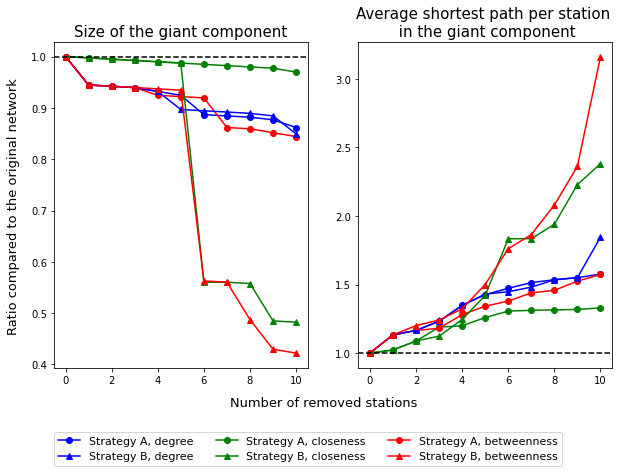

In [255]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (10,6))
text = fig.supxlabel('Number of removed stations', y=0.03, fontsize = '13')
text2 = fig.supylabel('Ratio compared to the original network', x=0.06, fontsize = '13')

# 1st subplot
axes[0].set_title('Size of the giant component',fontsize = '15')
axes[0].plot(df_degree_A['maxsize_normed'],'-bo', label='Strategy A, degree')
axes[0].plot(df_closeness_A['maxsize_normed'],'-go', label='Strategy A, closeness')
axes[0].plot(df_betweenness_A['maxsize_normed'],'-ro', label='Strategy A, betweenness')
axes[0].plot(df_degree_B['maxsize_normed'],'-b^', label='Strategy B, degree')
axes[0].plot(df_closeness_B['maxsize_normed'],'-g^', label='Strategy B, closeness')
axes[0].plot(df_betweenness_B['maxsize_normed'],'-r^', label='Strategy B, betweenness')
axes[0].axhline(1, linestyle='--', color = 'k')

# 2nd subplot
axes[1].set_title('Average shortest path per station \n in the giant component',fontsize = '15')
axes[1].plot(df_degree_A['avlength per node_normed'],'-bo', label='Strategy A, degree')
axes[1].plot(df_closeness_A['avlength per node_normed'],'-go', label='Strategy A, closeness')
axes[1].plot(df_betweenness_A['avlength per node_normed'],'-ro', label='Strategy A, betweenness')
axes[1].plot(df_degree_B['avlength per node_normed'],'-b^', label='Strategy B, degree')
axes[1].plot(df_closeness_B['avlength per node_normed'],'-g^', label='Strategy B, closeness')
axes[1].plot(df_betweenness_B['avlength per node_normed'],'-r^', label='Strategy B, betweenness')
axes[1].axhline(1, linestyle='--', color = 'k')

# legend
handles, labels = axes[1].get_legend_handles_labels()
order = [0,3,1,4,2,5]
#add legend to plot
legend = axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       loc=(-1.2, -0.3), ncol=3, fontsize = '11')

fig.savefig('Part 1I Impact calc', bbox_extra_artists=(legend,text,text2), bbox_inches='tight')

### II. Flows: weighted network

#### II.1. Centrality measure

- Use <b>betweenness centrality</b> for this section, as Part 1I showed that this is the most significant measure for spotting vulnerable station shut-downs.
- Incorporate weight = 1/flows, as weight represents distance; i.e. larger value in weight = less strongly connected

In [56]:
# Computing each measures - betweenness centrality
betweenness_w_dict =nx.betweenness_centrality(G, weight = 'inv_flows')
nx.set_node_attributes(G,dict(betweenness_w_dict),'betweenness_w')

In [57]:
# Creating a dataframe with station name and 3 centrality measures
df = pd.DataFrame()
#df['station_name'] = G.nodes()
#df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
#df['topological closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df['weighted betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))
df['topological betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

In [58]:
# Check the top 10 for degree centrality
df_sorted_bet_w = df.sort_values(["weighted betweenness"], ascending=False)
df_sorted_bet_w[0:10]

,weighted betweenness,topological betweenness
Green Park,0.568902,0.213964
Bank and Monument,0.505209,0.288474
Waterloo,0.409238,0.236992
Westminster,0.377581,0.200884
Liverpool Street,0.336911,0.270703
Stratford,0.331671,0.298351
Bond Street,0.292191,0.141132
Euston,0.283774,0.209004
Oxford Circus,0.269863,0.053484
Warren Street,0.253446,0.042446


Output table:

| Rank | Weighted betweenness centrality || Topological betweenness centrality ||
| -: | -: | :- | -: | :- |
| <b>1</b> | Green Park | 0.5689 | Stratford | 0.2984 |
| <b>2</b> | Bank and Monument  | 0.5052 | Bank and Monument | 0.2885 |
| <b>3</b> | Waterloo | 0.4092 | Liverpool Street | 0.2707 |
| <b>4</b> | Westminster | 0.3776 | King's Cross St. Pancras | 0.2566 |
| <b>5</b> | Liverpool Street | 0.3369 | Waterloo | 0.2370 |
| <b>6</b> | Stratford | 0.3317 | Gren Park |0.2140 |
| <b>7</b> | Bond Street | 0.2922 | Euston | 0.2090 |
| <b>8</b> | Euston | 0.2838 | Westminster | 0.2009 |
| <b>9</b> | Oxford Circus | 0.2699 | Baker Street | 0.1917 |
| <b>10</b> | Warren Street | 0.2534 | Finchley Road | 0.1653 |

*Table 3. Weighted and topological betweenness centrality*

#### II.2. Impact measures - refer to the word doc
- % of flows in the largest component
- Average shortest path (1/flow) per station in the largest component

In [59]:
def passenger_in_maxsize(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    passengers = 0
    for edge in G_maxsub.edges():
        (u,v) = edge
        passengers = passengers + G_maxsub.get_edge_data(u,v)['flows']
    
    return passengers

In [60]:
# This is the total flow
passenger_in_maxsize(G)

9930847

In [61]:
# Weighted average of the shortest distance

In [62]:
# Reading in the OD matrix
df_OD = pd.read_csv("london_flows.csv")

In [63]:
def weighted_avg_in_maxsize(G):
    # Create a "subgraph" of the largest component
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)

    # initialize counters
    weight_sum = 0
    flow_sum = 0
    origin_count = 0

    for origin in G_maxsub:
        #print("now adding routes from", origin)
        for destination in G_maxsub:

            if destination != origin:
                try:
                    path_flow = df_OD[(df_OD['station_origin']==origin) & (df_OD['station_destination']==destination)].flows.values[0]
                    path_length = nx.shortest_path_length(G, origin, destination)
                    
                    # add to counters
                    weight_sum += path_length*path_flow
                    flow_sum += path_flow

                except:
                    continue
            else:
                continue
        
        origin_count += 1
        if origin_count in [100,200,300]:
            print('origin count:', origin_count)

    weighted_average = weight_sum / flow_sum
    return weighted_average

In [64]:
### Run this chunk in Google Colab, due to limited capacity on local#
#weighted_avg_in_maxsize(G)

#output: 6.43500662790494

#### II.3. Node removal

In [65]:
G_rm = G.copy()
G_rm_w = G.copy()

# Identify the max centrality node using topological betweenness
centrality_list=[(i[1]['betweenness_t']) for i in G_rm.nodes(data=True)]
max_node=[n for n in G_rm.nodes() if G_rm.nodes[n]['betweenness_t'] == max(centrality_list)][0] # If multiple max centrality nodes, choose one
station_name = [key for key, value in G_rm.nodes(data=True) if G_rm.nodes[key]['betweenness_t'] == max(centrality_list)][0]
print("max centrality to be removed:", max(centrality_list))
print("node name to be removed:", station_name)

# Identify the max centrality node using weighted betweenness
centrality_list_w=[(i[1]['betweenness_w']) for i in G_rm_w.nodes(data=True)]
max_node_w=[n for n in G_rm.nodes() if G_rm_w.nodes[n]['betweenness_w'] == max(centrality_list_w)][0] # If multiple max centrality nodes, choose one
station_name = [key for key, value in G_rm_w.nodes(data=True) if G_rm_w.nodes[key]['betweenness_w'] == max(centrality_list_w)][0]
print("max centrality to be removed:", max(centrality_list_w))
print("node name to be removed:", station_name)

# Remove the node
G_rm.remove_node(max_node)
G_rm_w.remove_node(max_node_w)

# Evaluate the network efficiency
print('Passenger % in the largest component after removing max topological betweenness: ', 
      passenger_in_maxsize(G_rm)/passenger_in_maxsize(G))
print('Passenger % in the largest component after removing max weighted betweenness: ', 
      passenger_in_maxsize(G_rm_w)/passenger_in_maxsize(G))

### Run this bit on Google Colab due to computational intensity ###
#print('Weighted average of the shortest paths before removal: ', weighted_avg_in_maxsize(G)) 
#print('Weighted average after removing max topological betweenness: ', weighted_avg_in_maxsize(G_rm))
#print('Weighted average after removing max weighted betweenness: ', weighted_avg_in_maxsize(G_rm_w))


max centrality to be removed: 0.298350612436786
node name to be removed: Stratford
max centrality to be removed: 0.5689024467425288
node name to be removed: Green Park
Passenger % in the largest component after removing max topological betweenness:  0.9405905659406494
Passenger % in the largest component after removing max weighted betweenness:  0.9366980480114133


From Google Colab:
- "Weighted average of the shortest paths before removal:  6.43500662790494"
- "Weighted average after removing max topological betweenness:  6.698491504158406"
- "Weighted average after removing max weighted betweenness:  6.790683758366718"

## Part 2: Spatial interaction models

In [66]:
# Reading in the OD matrix
df_OD = pd.read_csv("london_flows.csv")

In [67]:
df_OD.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [68]:
# Remove entries where orig = dest
df_OD = df_OD.loc[df_OD["station_origin"] != df_OD["station_destination"]]

In [69]:
# Remove entries where orig or dest is Battersea Park
df_OD.drop(df_OD[df_OD["station_origin"] == "Battersea Park"].index, inplace = True)
df_OD.drop(df_OD[df_OD["station_destination"] == "Battersea Park"].index, inplace = True)

#### Pivot table for checking total conservation

In [70]:
# Creating a pivot table from the long list
df_OD_pivot_actual = pd.pivot_table(df_OD, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True).fillna(0)

In [71]:
df_OD_pivot_actual.sort_values(by='All').tail(5)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
London Bridge,0.0,0.0,24.0,20.0,47.0,0.0,9.0,1.0,0.0,905.0,...,0.0,1.0,52.0,1.0,0.0,5.0,0.0,9.0,0.0,32593
Victoria,0.0,0.0,30.0,59.0,153.0,0.0,9.0,2.0,0.0,235.0,...,53.0,2.0,122.0,2.0,0.0,7.0,0.0,26.0,0.0,37517
Stratford,223.0,25.0,7.0,18.0,186.0,157.0,3.0,0.0,0.0,167.0,...,3.0,4.0,43.0,1.0,0.0,133.0,0.0,8.0,1106.0,59311
Waterloo,0.0,0.0,14.0,108.0,381.0,0.0,6.0,1.0,0.0,306.0,...,2.0,0.0,43.0,5.0,0.0,12.0,0.0,18.0,0.0,67314
All,345.0,750.0,2202.0,7782.0,7932.0,444.0,741.0,256.0,173.0,8103.0,...,6295.0,596.0,2146.0,1578.0,404.0,706.0,242.0,745.0,4428.0,1542283


### III. Models

#### III.1. Spatial interaction models - equations and parameters

#### 4 types of gravity model

- Unconstrained model: formula = <b> 'Total ~ log_Oi1_origpop + log_Dj2_destsal + log_Dist' <b>
    
\begin{equation} \tag{1}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{2}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij}
\end{equation}

\begin{equation} \tag{3}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

where intercept = K = ln(k), alpha = coef(log_Oi1_origpop), gamma = coef(log_Dj2_destsal), beta = -coef(log_Dist)
<br>

- Production constrained model: <b> 'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1' <b>
    
\begin{equation} \tag{4a}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{4b}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{4c}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{5}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

where　$\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, which is a dummy variable. Alpha includes $O_i$ information as a categorical parameter.

- Attraction constrained model: <b> 'Total ~ DestCodeNew + log_Oi1_origpop + log_Dist-1' <b>
    
\begin{equation} \tag{6a}
T_{ij} = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{6b}
D_j = \sum_i T_{ij}
\end{equation}

\begin{equation} \tag{6c}
B_j = \frac{1}{\sum_i O_i^\alpha d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{7}
\lambda_{ij} = \exp (\alpha \ln O_i + \gamma_i - \beta \ln d_{ij})
\end{equation}

- Doubly constrained model: <b> 'Total ~ Dest + Orig + log_Dist-1' <b>
   
\begin{equation} \tag{8a}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{8b}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{8c}
D_j = \sum_i T_{ij} 
\end{equation}

\begin{equation} \tag{8d}
A_i = \frac{1}{\sum_j B_j D_j d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{8e}
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}}
\end{equation}
    
\begin{equation} \tag{9}
\lambda_{ij} = \exp (\alpha_i + \gamma_j -\beta \ln d_{ij})
\end{equation}


#### To use negative exponential for distance decay, substitute 'log_Dist' with 'Dist' in formula

\begin{equation} \tag{1'}
T_{ij} = k O_i^\alpha  D_j^\gamma  \exp (-\beta d_{ij})
\end{equation}

\begin{equation} \tag{2'}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta d_{ij}
\end{equation}

\begin{equation} \tag{3'}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta d_{ij})
\end{equation}

In [328]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt

In [73]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    return R2

def CalcRMSE(observed, estimated):    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    return RMSE

In [136]:
# Fitting the model
def model_predict(dataframe, formula):

    #run a model
    model = smf.glm(formula, data=dataframe, family=sm.families.Poisson()).fit()
    predictions = model.get_prediction()
    predictions_summary_frame = predictions.summary_frame()
    
    dataframe[formula] = predictions_summary_frame["mean"]
    
    #round and convert to integers
    dataframe[formula] = round(dataframe[formula], 0)
    dataframe[formula] = dataframe[formula].astype(int)
    
    '''
    #show the results as a pivot table
    pivot_table = dataframe.pivot_table(values =formula, index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
    print(pivot_table)
    '''

    #calculate the metric
    Rsq = CalcRSqaured(df_OD["flows"], df_OD[formula])
    RMSE = CalcRMSE(df_OD["flows"], df_OD[formula])
    
    return (sum(dataframe[formula]), Rsq, RMSE, model.summary(), model.params)

### III.2. Production constrained model calibration

In [137]:
# Create logged variables - population and distance
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    df_OD[f"log_{x}"] = np.log(df_OD[x])
    log_x_vars.append(f"log_{x}")

In [138]:
df_OD.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,flows ~ station_origin + log_jobs + log_distance-1,...,Dd_scenario_B1,Dd_scenario_B2,Ai_scenario_B1,Ai_scenario_B2,flows_scenario_B1,flows_scenario_B2,Ai_initial_y,Ai_initial,Ai_scenario_A_y,Ai_scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.010681,...,768.354601,118.633538,0.000119,0.00022,55.0,16.0,0.000091,0.000091,0.000097,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.986106,...,14.084773,1.993516,0.000119,0.00022,1.0,0.0,0.000091,0.000091,0.000097,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2.755640,...,56.904408,23.902095,0.000119,0.00022,4.0,3.0,0.000091,0.000091,0.000097,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,66.457296,...,1242.378620,386.124568,0.000119,0.00022,89.0,51.0,0.000091,0.000091,0.000097,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,49.060970,...,872.373508,522.760880,0.000119,0.00022,62.0,69.0,0.000091,0.000091,0.000097,0.000097


#### Run the model

In [139]:
# Define list of formulas
formula_list = [
    #'flows ~ log_population + log_jobs + log_distance', # unconstrained power
    #'flows ~ log_population + log_jobs + distance', # unconstrained exponential
    'flows ~ station_origin + log_jobs + log_distance-1', # production constrained power
    'flows ~ station_origin + log_jobs + distance-1', # production constrained exponential
    #'flows ~ station_destination + log_population + log_distance-1', # attraction constrained power
    #'flows ~ station_destination + log_population + distance-1', # attraction constrained exponential
    #'flows ~ station_destination + station_origin + log_distance-1', # doubly constrained power
    #'flows ~ station_destination + station_origin + distance-1' # doubly constrained exponential
]

In [140]:
# Run the model -> output: (total, R2, RSME) + parameters
for formula in formula_list:
    (Total, Rsq, RMSE, summary, parameters) = model_predict(df_OD, formula) # final: exponential - to use
    print('Total: ', Total, 'Rsq: ', Rsq, 'RMSE: ', RMSE, '\n', parameters)

# Results (prod - power): total 1541806 (good), R2 0.388, RSME 103, gamma 0.7451, beta 0.6351*lnd, with p value 0.000
# Results (prod - exponential): total 1541347 (good), R2 0.468, RSME 96, gamma 0.7552, beta 0.0002, with p value 0.000    

##########
# Results (attr - power): total 1542244 (good), R2 0.350, RSME 106, alpha 0.745, beta 0.635*lnd, with p value 0.000
# Results (attr - exponential): total 1542158 (good), R2 0.400, RSME 102, alpha 0.715, beta -0.000100, with p value 0.000
##########

Total:  1541806 Rsq:  0.38827639501786243 RMSE:  102.893 
 station_origin[Abbey Road]          3.250242
station_origin[Acton Central]       5.016902
station_origin[Acton Town]          4.562892
station_origin[Aldgate]             3.323767
station_origin[Aldgate East]        3.457664
                                      ...   
station_origin[Woodgrange Park]     5.254667
station_origin[Woodside Park]       4.698635
station_origin[Woolwich Arsenal]    6.905590
log_jobs                            0.768616
log_distance                       -0.878119
Length: 400, dtype: float64
Total:  1541347 Rsq:  0.4680648443542878 RMSE:  96.263 
 station_origin[Abbey Road]         -2.914322
station_origin[Acton Central]      -1.162092
station_origin[Acton Town]         -1.613081
station_origin[Aldgate]            -2.943047
station_origin[Aldgate East]       -2.854752
                                      ...   
station_origin[Woodgrange Park]    -0.896422
station_origin[Woodside Park]      -1.149110
s

In [141]:
df_OD.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,flows ~ station_origin + log_jobs + log_distance-1,...,Dd_scenario_B1,Dd_scenario_B2,Ai_scenario_B1,Ai_scenario_B2,flows_scenario_B1,flows_scenario_B2,Ai_initial_y,Ai_initial,Ai_scenario_A_y,Ai_scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55,...,768.354601,118.633538,0.000119,0.00022,55.0,16.0,0.000091,0.000091,0.000097,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,14.084773,1.993516,0.000119,0.00022,1.0,0.0,0.000091,0.000091,0.000097,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,...,56.904408,23.902095,0.000119,0.00022,4.0,3.0,0.000091,0.000091,0.000097,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,66,...,1242.378620,386.124568,0.000119,0.00022,89.0,51.0,0.000091,0.000091,0.000097,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,49,...,872.373508,522.760880,0.000119,0.00022,62.0,69.0,0.000091,0.000091,0.000097,0.000097
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,...,45.758803,9.847043,0.000119,0.00022,3.0,1.0,0.000091,0.000091,0.000097,0.000097
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,3,...,67.419524,27.999224,0.000119,0.00022,5.0,4.0,0.000091,0.000091,0.000097,0.000097
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,3,...,39.840800,5.647013,0.000119,0.00022,3.0,1.0,0.000091,0.000091,0.000097,0.000097
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,...,36.357586,8.106430,0.000119,0.00022,3.0,1.0,0.000091,0.000091,0.000097,0.000097
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,2,...,51.182494,20.614102,0.000119,0.00022,4.0,3.0,0.000091,0.000091,0.000097,0.000097


#### Output table

|| Negative power law | Negative exponential | 
| :- | :-: | :-: |
| beta | 0.878 | 1.53e-4 | 
| gamma | 0.769 | 0.755 |
||||
| Rsq | 0.388 | 0.468 | 
| RMSE | 103 | 96 | 
| Total flow (for check) | 1,542,283 | 1,542,283 | 


*Table 4. Production constrained model calibration results*

Both work similarly well -> choose exponential decay as it is more widely used for home-work distance decay

In [142]:
# save calibrated variables for <exponential, attraction constrained>
beta = -parameters[-1]
gamma = parameters[-2]
alpha = parameters[0:-3]

In [143]:
print(beta)
print(gamma)

0.0001531661934644325
0.7552215895693623


### IV. Scenarios

#### IV.1. Scenario A: 50% decrease in jobs at Canary Wharf

In [144]:
# Function to alter attraction
def new_job(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"]/2
    else:
        val = row["jobs"]
    return val
        
df_OD["jobs_scenario_A"] = df_OD.apply(new_job, axis =1)
df_OD.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,flows ~ station_origin + log_jobs + log_distance-1,...,Dd_scenario_B1,Dd_scenario_B2,Ai_scenario_B1,Ai_scenario_B2,flows_scenario_B1,flows_scenario_B2,Ai_initial_y,Ai_initial,Ai_scenario_A_y,Ai_scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55,...,768.354601,118.633538,0.000119,0.00022,55.0,16.0,0.000091,0.000091,0.000097,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,14.084773,1.993516,0.000119,0.00022,1.0,0.0,0.000091,0.000091,0.000097,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,...,56.904408,23.902095,0.000119,0.00022,4.0,3.0,0.000091,0.000091,0.000097,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,66,...,1242.378620,386.124568,0.000119,0.00022,89.0,51.0,0.000091,0.000091,0.000097,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,49,...,872.373508,522.760880,0.000119,0.00022,62.0,69.0,0.000091,0.000091,0.000097,0.000097
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,...,45.758803,9.847043,0.000119,0.00022,3.0,1.0,0.000091,0.000091,0.000097,0.000097
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,3,...,67.419524,27.999224,0.000119,0.00022,5.0,4.0,0.000091,0.000091,0.000097,0.000097
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,3,...,39.840800,5.647013,0.000119,0.00022,3.0,1.0,0.000091,0.000091,0.000097,0.000097
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,...,36.357586,8.106430,0.000119,0.00022,3.0,1.0,0.000091,0.000091,0.000097,0.000097
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,2,...,51.182494,20.614102,0.000119,0.00022,4.0,3.0,0.000091,0.000091,0.000097,0.000097


In [145]:
# To check:
#df_OD[df_OD["station_destination"] =="Canary Wharf"] 

- Production constrained model: <b> 'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1' <b>
    
\begin{equation} \tag{4a}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{4b}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{4c}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{5}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

where　$\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, which is a dummy variable. Alpha includes $O_i$ information as a categorical parameter.

#### To use negative exponential for distance decay, substitute 'log_Dist' with 'Dist' in formula

\begin{equation} \tag{1'}
T_{ij} = k O_i^\alpha  D_j^\gamma  \exp (-\beta d_{ij})
\end{equation}

\begin{equation} \tag{2'}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta d_{ij}
\end{equation}

\begin{equation} \tag{3'}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta d_{ij})
\end{equation}

Origin and distance terms unchanged -> 
1. Calculate D^gamma and d^-beta
2. Find Ai for new Dj
3. Find estimates based on the new Ai and Dj

In [148]:
#calculate new wj^alpha and d_ij^beta values
D_term_initial = df_OD["jobs"]**gamma
dist_term_initial = np.exp(df_OD["distance"]*-beta)
#calcualte the first stage of the D*d values
df_OD["Dd"] = D_term_initial * dist_term_initial
#now do the sum over all js bit
A_i = pd.DataFrame(df_OD.groupby(["station_origin"])["Dd"].agg(np.sum))
#now divide into 1
A_i["Dd"] = 1/A_i["Dd"]
A_i.rename(columns={"Dd":"Ai_initial"}, inplace=True)
#and write the A_i values back into the dataframe
df_OD = df_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [149]:
#to check everything works, recreate the original estimates
df_OD["check"] = df_OD["Ai_initial"]*df_OD["population"]*D_term_initial*dist_term_initial
#round
df_OD["check"] = round(df_OD["check"])

In [150]:
#check
df_OD[["flows","flows ~ station_origin + log_jobs + distance-1","check"]]

,flows,flows ~ station_origin + log_jobs + distance-1,check
0,0,78,78.0
1,1,1,1.0
2,3,4,4.0
3,1,99,99.0
4,37,56,56.0
...,...,...,...
61469,127,99,99.0
61470,608,295,295.0
61471,6,36,36.0
61472,81,125,125.0


In [152]:
#calculate new ^gamma value
D_term_scenario_A = df_OD["jobs_scenario_A"]**gamma
#calcualte the first stage of the Ai values
df_OD["Dd_scenario_A"] = D_term_scenario_A * dist_term_initial
#now do the sum over all js bit
A_i = pd.DataFrame(df_OD.groupby(["station_origin"])["Dd_scenario_A"].agg(np.sum))
#now divide into 1
A_i["Dd_scenario_A"] = 1/A_i["Dd_scenario_A"]
A_i.rename(columns={"Dd_scenario_A":"Ai_scenario_A"}, inplace=True)
#and write the A_i values back into the dataframe
df_OD = df_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [153]:
#to check everything works, recreate the original estimates
df_OD["flows_scenario_A"] = df_OD["Ai_scenario_A"]*df_OD["population"]*D_term_scenario_A * dist_term_initial
#round
df_OD["flows_scenario_A"] = round(df_OD["flows_scenario_A"])

In [154]:
#check
df_OD[["station_origin", "station_destination", "flows",
       "flows ~ station_origin + log_jobs + distance-1","check", "flows_scenario_A"]]

,station_origin,station_destination,flows,flows ~ station_origin + log_jobs + distance-1,check,flows_scenario_A
0,Abbey Road,Bank and Monument,0,78,78.0,83.0
1,Abbey Road,Beckton,1,1,1.0,2.0
2,Abbey Road,Blackwall,3,4,4.0,4.0
3,Abbey Road,Canary Wharf,1,99,99.0,63.0
4,Abbey Road,Canning Town,37,56,56.0,60.0
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,99,99.0,107.0
61470,Woolwich Arsenal,West Ham,608,295,295.0,320.0
61471,Woolwich Arsenal,West India Quay,6,36,36.0,39.0
61472,Woolwich Arsenal,West Silvertown,81,125,125.0,135.0


In [155]:
# check total -> good
df_OD['flows_scenario_A'].sum()

1541504.0

#### IV.2. Scenario B: Significant increase in the cost of transport - choosing 2 hypothetical cost parameters 

In [210]:
# larger beta values for steeper decay (more cost)
beta_1 = beta*1.2
beta_2 = beta*1.4

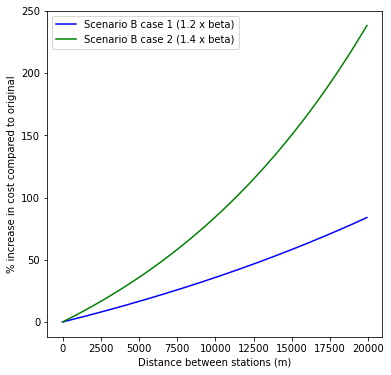

In [216]:
# This means:

#xs = np.arange(1.0,61000,100)
xs = np.arange(1.0,20000,100)

# negative exponential, beta = 1.53e-4
y_neg_exp_point = np.exp(beta * xs)
y_neg_exp_point_1 = (np.exp(beta_1 * xs)/y_neg_exp_point-1)*100
y_neg_exp_point_2 = (np.exp(beta_2 * xs)/y_neg_exp_point-1)*100

# Now a plot.
f, ax = plt.subplots(figsize=(6,6))
#ax.plot(xs,y_neg_exp_point, label = 'Original transport cost', color = "red")
ax.plot(xs,y_neg_exp_point_1, label = 'Scenario B case 1 (1.2 x beta)', color = "blue")
ax.plot(xs,y_neg_exp_point_2, label = 'Scenario B case 2 (1.4 x beta)', color = "green")
plt.xlabel('Distance between stations (m)')
plt.ylabel('% increase in cost compared to original')
ax.legend();

In [92]:
#df_OD.drop("Ai_scenario_B2_y", axis = 1, inplace=True)

In [228]:
# Recompute A1 with dist_term_new_1 and dist_term_new_2
#calculate new ^beta values
dist_term_scenario_B1 = np.exp(df_OD["distance"]*-beta_1)
dist_term_scenario_B2 = np.exp(df_OD["distance"]*-beta_2)

#calcualte the first stage of the Ai values
df_OD["Dd_scenario_B1"] = D_term_initial * dist_term_scenario_B1
df_OD["Dd_scenario_B2"] = D_term_initial * dist_term_scenario_B2

#now do the sum over all js bit
A_i1 = pd.DataFrame(df_OD.groupby(["station_origin"])["Dd_scenario_B1"].agg(np.sum))
A_i2 = pd.DataFrame(df_OD.groupby(["station_origin"])["Dd_scenario_B2"].agg(np.sum))

#now divide into 1
A_i1["Dd_scenario_B1"] = 1/A_i1["Dd_scenario_B1"]
A_i2["Dd_scenario_B2"] = 1/A_i2["Dd_scenario_B2"]
A_i1.rename(columns={"Dd_scenario_B1":"Ai_scenario_B1"}, inplace=True)
A_i2.rename(columns={"Dd_scenario_B2":"Ai_scenario_B2"}, inplace=True)

#and write the A_i values back into the dataframe
df_OD = df_OD.merge(A_i1, left_on="station_origin", right_index=True, how="left")
df_OD = df_OD.merge(A_i2, left_on="station_origin", right_index=True, how="left")

In [229]:
# Find flows
df_OD['flows_scenario_B1'] = df_OD["Ai_scenario_B1"]*df_OD["population"]*D_term_initial * dist_term_scenario_B1
df_OD['flows_scenario_B2'] = df_OD["Ai_scenario_B2"]*df_OD["population"]*D_term_initial * dist_term_scenario_B2

#round
df_OD["flows_scenario_B1"] = round(df_OD["flows_scenario_B1"])
df_OD["flows_scenario_B2"] = round(df_OD["flows_scenario_B2"])

In [230]:
#check
df_OD[["station_origin", "station_destination", "flows", 
       "flows ~ station_origin + log_jobs + distance-1", "check", 
       "flows_scenario_A", 'flows_scenario_B1', 'flows_scenario_B2']]

,station_origin,station_destination,flows,flows ~ station_origin + log_jobs + distance-1,check,flows_scenario_A,flows_scenario_B1,flows_scenario_B2
0,Abbey Road,Bank and Monument,0,78,78.0,83.0,68.0,59.0
1,Abbey Road,Beckton,1,1,1.0,2.0,1.0,1.0
2,Abbey Road,Blackwall,3,4,4.0,4.0,4.0,4.0
3,Abbey Road,Canary Wharf,1,99,99.0,63.0,95.0,91.0
4,Abbey Road,Canning Town,37,56,56.0,60.0,59.0,61.0
...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,99,99.0,107.0,88.0,78.0
61470,Woolwich Arsenal,West Ham,608,295,295.0,320.0,303.0,309.0
61471,Woolwich Arsenal,West India Quay,6,36,36.0,39.0,36.0,36.0
61472,Woolwich Arsenal,West Silvertown,81,125,125.0,135.0,142.0,161.0


In [231]:
# check total
print(df_OD['flows_scenario_B1'].sum())
print(df_OD['flows_scenario_B2'].sum())

1541255.0
1541035.0


#### IV.3. Comparing scenario impacts

In [232]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}
flows_model = {(u,v): 0 for u,v in G.edges()}
flows_scenario_A = {(u,v): 0 for u,v in G.edges()}
flows_scenario_B1 = {(u,v): 0 for u,v in G.edges()}
flows_scenario_B2 = {(u,v): 0 for u,v in G.edges()}

In [233]:
#calculate shortest paths for all flows and add data to dict
for i, row in df_OD.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
            flows_model[(u,v)] += row.check
            flows_scenario_A[(u,v)] += row.flows_scenario_A
            flows_scenario_B1[(u,v)] += row.flows_scenario_B1
            flows_scenario_B2[(u,v)] += row.flows_scenario_B2
        except:
            flows[(v,u)] += row.flows
            flows_model[(v,u)] += row.check
            flows_scenario_A[(v,u)] += row.flows_scenario_A
            flows_scenario_B1[(v,u)] += row.flows_scenario_B1
            flows_scenario_B2[(v,u)] += row.flows_scenario_B2

In [235]:
#set this as a network attribute
nx.set_edge_attributes(G, flows_model, 'flows_model')
nx.set_edge_attributes(G, flows_scenario_A, 'flows_scenario_A')
nx.set_edge_attributes(G, flows_scenario_B1, 'flows_scenario_B1')
nx.set_edge_attributes(G, flows_scenario_B2, 'flows_scenario_B2')

In [236]:
# Add change in flow for A, B1, B2:
change_model={(e1, e2): (data['flows_model'] - data['flows'])/data['flows'] for e1, e2, data in G.edges(data=True)}
change_A={(e1, e2): (data['flows_scenario_A'] - data['flows_model'])/data['flows_model'] for e1, e2, data in G.edges(data=True)}
change_B1={(e1, e2):(data['flows_scenario_B1'] - data['flows_model'])/data['flows_model'] for e1, e2, data in G.edges(data=True)}
change_B2={(e1, e2):(data['flows_scenario_B2'] - data['flows_model'])/data['flows_model'] for e1, e2, data in G.edges(data=True)}

# Let us add the inversed flows as an attribute to the edges in the graph
nx.set_edge_attributes(G, change_model, 'change_model')
nx.set_edge_attributes(G, change_A, 'change_A')
nx.set_edge_attributes(G, change_B1, 'change_B1')
nx.set_edge_attributes(G, change_B2, 'change_B2')

# Print edge list with attributes
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483,
  'line_name': 'Jubilee',
  'flows': 12356,
  'inv_flows': 8.09e-05,
  'flows_model': 11505.0,
  'flows_scenario_A': 11521.0,
  'flows_scenario_B1': 11131.0,
  'flows_scenario_B2': 10717.0,
  'change_model': -0.06887342181935902,
  'change_A': 0.0013906996957844416,
  'change_B1': -0.03250760538896132,
  'change_B2': -0.06849196001738375})

#### Plot!

In [296]:
def plot_flows_Canary(G, attribute, column:str):
    flows_values = attribute.values()
    flow_color=[(i[2][column]/max(flows_values)) for i in G.edges(data=True)]
    flow_width=[(i[2][column]/max(flows_values)*10) for i in G.edges(data=True)]

    # Plot graph
    fig, ax = plt.subplots(figsize=(12, 9))
    edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
    nx.draw_networkx_nodes(G,
            label=label,
            pos = pos,
            node_color= 'black',
            node_size= 1)

    plt.colorbar(edg,label="Passenger Flows (normalised)",orientation="horizontal", shrink=0.5, pad = 0.02)
    plt.axis("off")
    plt.title("London network Passenger Flows: " + column,fontsize=15)
    plt.show()

In [297]:
def plot_flows(G, attribute, column:str):
    flows_values = attribute.values()
    flow_color=[(i[2][column]/max(flows_values)) for i in G.edges(data=True)]
    flow_width=[(i[2][column]/max(flows_values)*10) for i in G.edges(data=True)]

    # Plot graph
    fig, ax = plt.subplots(figsize=(12,12))
    edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
    nx.draw_networkx_nodes(G,
            label=label,
            pos = pos,
            node_color= 'black',
            node_size= 1)

    plt.colorbar(edg,label="Passenger Flows (normalised)",orientation="horizontal", shrink=0.5, pad = 0.02)
    plt.axis("off")
    plt.title("London network Passenger Flows: " + column,fontsize=15)
    plt.show()

1. Actual flow

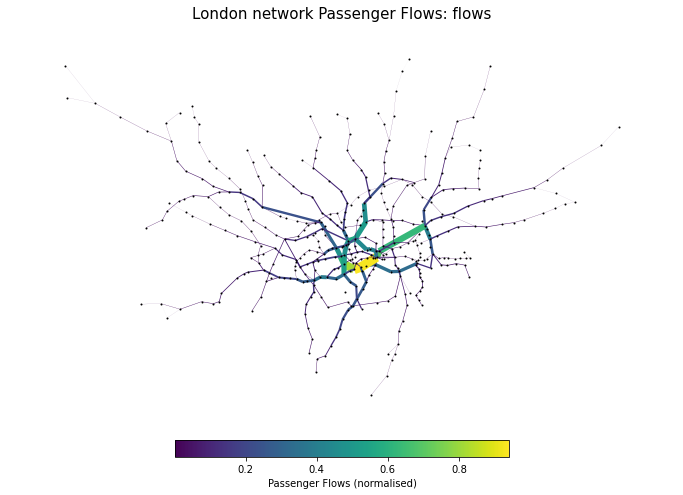

In [298]:
plot_flows_Canary(G, flows,'flows')

2. Change between model and actual - how good is the model representation?

In [299]:
#plot_flows_Canary(G, flows_model, 'flows_model')

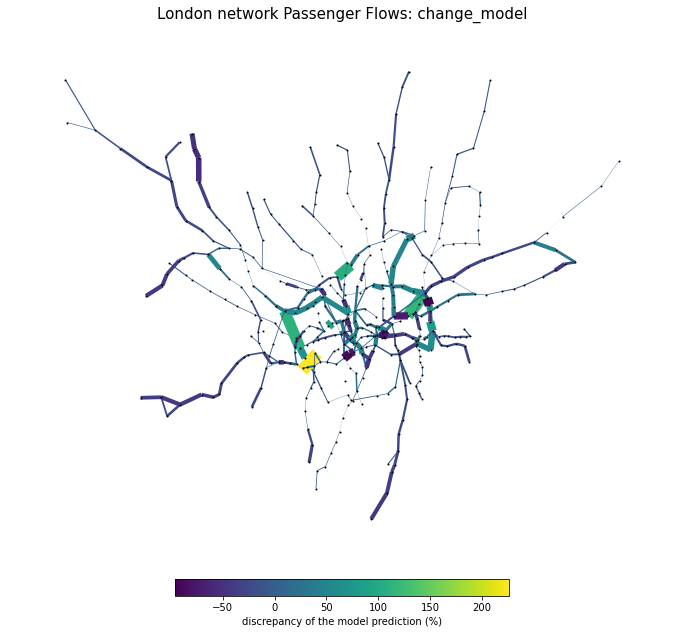

In [301]:
# Change - Actual and model
#flows_values = change_model.values()
flow_color=[(i[2]['change_model']*100) for i in G.edges(data=True)]
flow_width=[(i[2]['change_model']*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
#        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="discrepancy of the model prediction (%)",orientation="horizontal", shrink=0.5, pad = 0.02)
plt.axis("off")
plt.title("London network Passenger Flows: change_model",fontsize=15)
plt.show()

3. Scenario A

In [107]:
#plot_flows_Canary(G, flows_scenario_A, 'flows_scenario_A')

In [323]:
stations_show = ['Stratford', 'Canada Water', 'Canning Town', 'Clapham Junction']

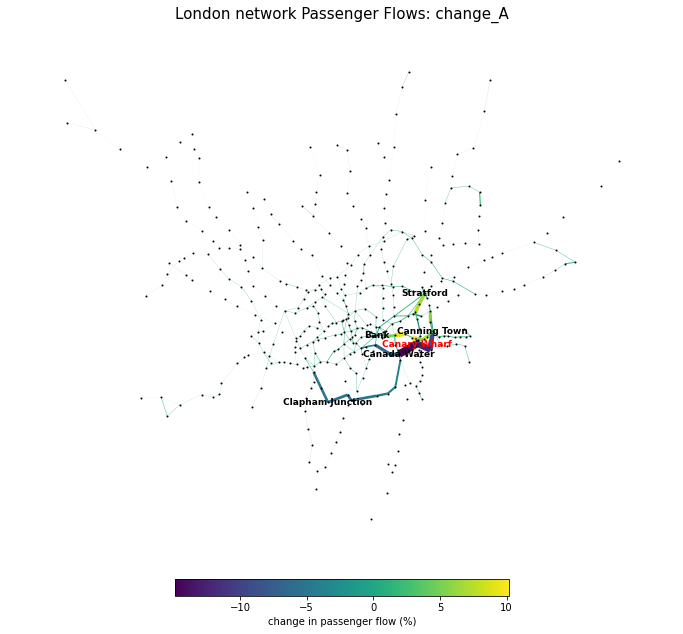

In [327]:
# Change - Scenario A
#flows_values = change_A.values()
flow_color=[(i[2]['change_A']*100) for i in G.edges(data=True)]
flow_width=[(i[2]['change_A']*50) for i in G.edges(data=True)]
label = {n: (n if n=="Canary Wharf" else '') for n in G.nodes}
label_t = {n: (n if n in stations_show else '') for n in G.nodes}
label_Bank = {n: ("Bank" if n=="Bank and Monument" else '') for n in G.nodes}

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)
nx.draw_networkx_labels(G, pos, label, font_size=9, font_color='red', font_weight = 'bold')
nx.draw_networkx_labels(G, pos, label_t, font_size=9, font_color='black', font_weight = 'bold')
nx.draw_networkx_labels(G, pos, label_Bank, font_size=9, font_color='black', font_weight = 'bold')

plt.colorbar(edg,label="change in passenger flow (%)",orientation="horizontal", shrink=0.5, pad = 0.02)
plt.axis("off")
plt.title("London network Passenger Flows: change_A",fontsize=15)
plt.show()

4_1. Scenario B case 1 (1.2*beta)

In [109]:
#plot_flows(G, flows_scenario_B1, 'flows_scenario_B1')

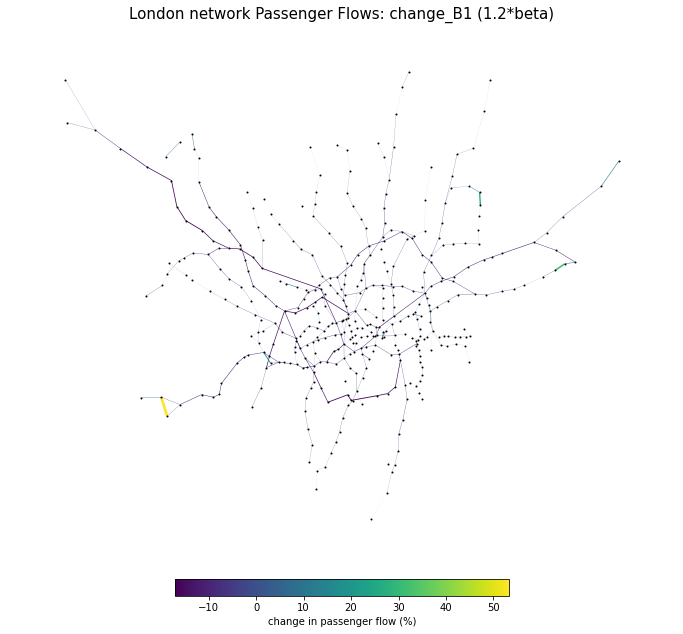

In [240]:
# Change - Scenario B1
#flows_values = change_B1.values()
flow_color=[(i[2]['change_B1']*100) for i in G.edges(data=True)]
flow_width=[(i[2]['change_B1']*5) for i in G.edges(data=True)]
#label = {n: (n if n=="Canary Wharf" else '') for n in G.nodes}

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)
#nx.draw_networkx_labels(G, pos, label, font_size=7, font_color='red', font_weight = 'bold')

plt.colorbar(edg,label="change in passenger flow (%)",orientation="horizontal", shrink=0.5, pad = 0.02)
plt.axis("off")
plt.title("London network Passenger Flows: change_B1 (1.2*beta)",fontsize=15)
plt.show()

4_2. Scenario B case 2 (1.4*beta)

In [111]:
#plot_flows(G, flows_scenario_B2, 'flows_scenario_B2')

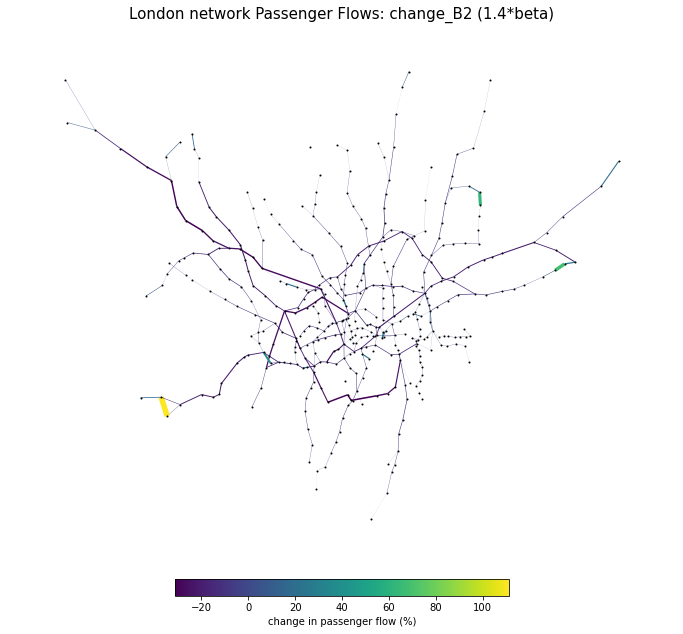

In [241]:
# Change - Scenario B2
#flows_values = change_B2.values()
flow_color=[(i[2]['change_B2']*100) for i in G.edges(data=True)]
flow_width=[(i[2]['change_B2']*5) for i in G.edges(data=True)]
#label = {n: (n if n=="Canary Wharf" else '') for n in G.nodes}

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)
#nx.draw_networkx_labels(G, pos, label, font_size=7, font_color='red', font_weight = 'bold')

plt.colorbar(edg,label="change in passenger flow (%)",orientation="horizontal", shrink=0.5, pad = 0.02)
plt.axis("off")
plt.title("London network Passenger Flows: change_B2 (1.4*beta)",fontsize=15)
plt.show()

In [ ]:
4. Scenario B1 (1.4*beta)

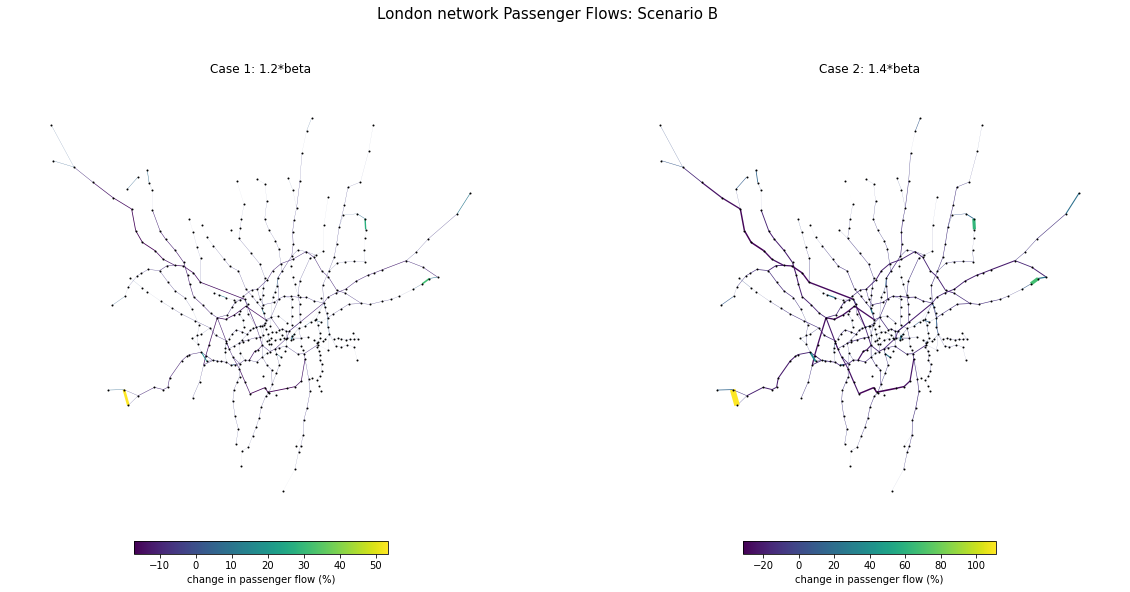

In [288]:
fig, axes = plt.subplots(1, 2, figsize = (20,10))
#axes = axes.flatten()
fig.suptitle("London network Passenger Flows: Scenario B",fontsize=15)

# 1st subplot
axes[0].axis("off")
axes[0].set_title('Case 1: 1.2*beta',fontsize = '12')
flow_color=[(i[2]['change_B1']*100) for i in G.edges(data=True)]
flow_width=[(i[2]['change_B1']*5) for i in G.edges(data=True)]
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width, ax = axes[0])
nx.draw_networkx_nodes(G,
        ax = axes[0],
        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)
plt.colorbar(edg,label="change in passenger flow (%)",orientation="horizontal", shrink=0.5, pad = 0.02, ax = axes[0])

# 2nd subplot
axes[1].axis("off")
axes[1].set_title('Case 2: 1.4*beta',fontsize = '12')
flow_color=[(i[2]['change_B2']*100) for i in G.edges(data=True)]
flow_width=[(i[2]['change_B2']*5) for i in G.edges(data=True)]
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width, ax = axes[1])
nx.draw_networkx_nodes(G,
        ax = axes[1],
        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)
plt.colorbar(edg,label="change in passenger flow (%)",orientation="horizontal", shrink=0.5, pad = 0.02, ax = axes[1])

fig.savefig('Change in flow B')

### *Mapping for weighted and topological centrality comparison

In [304]:
# Stations rankde higher in topological
stations_bet = ['Stratford', 'Liverpool Street', "King's Cross St. Pancras", 'Euston', 'Baker Street', 'Finchley Road']
stations_bet_w = ['Green Park', 'Waterloo', 'Westminster', 'Bond Street', 'Oxford Circus', 'Warren Street']

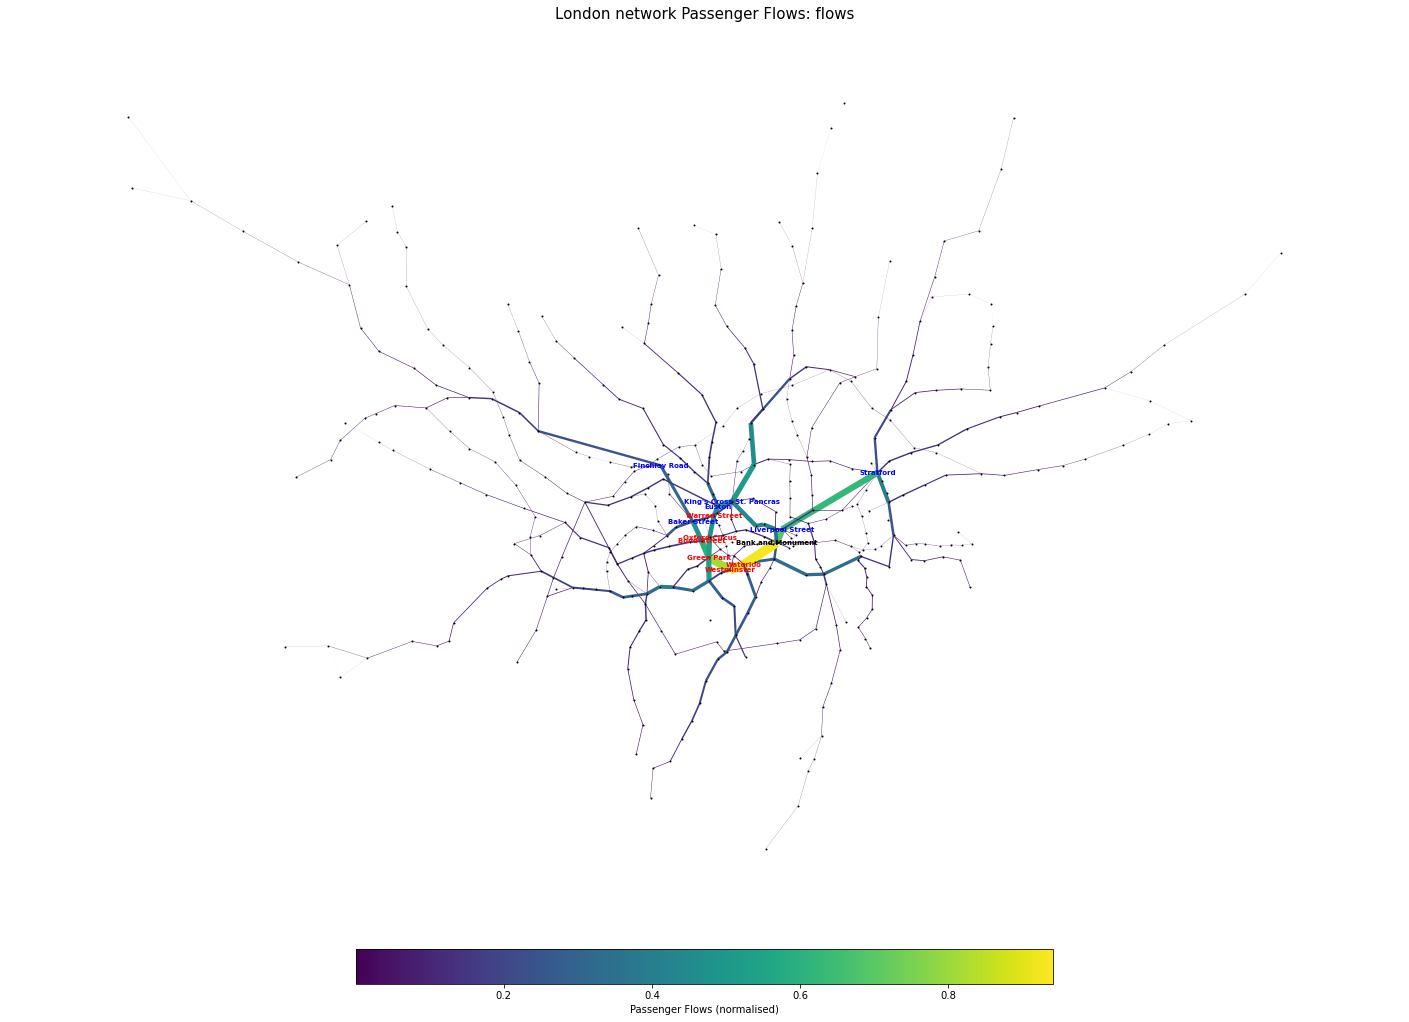

In [305]:
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

label_t = {n: (n if n in stations_bet else '') for n in G.nodes}
label_w = {n: (n if n in stations_bet_w else '') for n in G.nodes}
label = {n: (n if n=='Bank and Monument' else '') for n in G.nodes}

# Plot graph
fig, ax = plt.subplots(figsize=(25, 20))
edg=nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        label=label,
        pos = pos,
        node_color= 'black',
        node_size= 1)
nx.draw_networkx_labels(G, pos, label_t, font_size=7, font_color='blue', font_weight = 'bold')
nx.draw_networkx_labels(G, pos, label_w, font_size=7, font_color='red', font_weight = 'bold')
nx.draw_networkx_labels(G, pos, label, font_size=7, font_color='black', font_weight = 'bold')


plt.colorbar(edg,label="Passenger Flows (normalised)",orientation="horizontal", shrink=0.5, pad = 0.02)
plt.axis("off")
plt.title("London network Passenger Flows: flows",fontsize=15)
plt.show()

### *Note for Google Colab

1. Mouting drive
- from google.colab import drive
- drive.mount('/content/drive')
2. Reading files
- G = nx.read_graphml('/content/drive/My Drive/Colab_Notebooks/london.graph.xml')